# Détectez des faux billets

In [1]:
# import librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.formula.api import ols
from statsmodels.api import Logit
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as st
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import preprocessing, decomposition, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

In [2]:
df_billet = pd.read_csv("/Users/Hamza/Downloads/DAN-P10-data/billets.csv", sep=';')
df_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# Analyse descriptive des données

In [154]:
df_billet.info()
df_billet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [155]:
df_billet.is_genuine.unique()

array([ True, False])

In [156]:
df_billet.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [157]:
df_billet.duplicated().sum()

0

In [158]:
df_billet.shape

(1500, 7)

### Nous avons 6 variables quantitatives regroupant différentes données géométriques sur les billets + une variable de type booléen contenant le "label" (étiquette) de vrai ou faux. Aucun doublons dans nos données mais il y a 37 valeurs manquantes dans la variable "margin_low".


### Regardons le taux de vrais et faux billets.

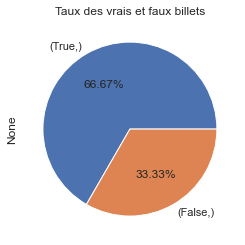

In [159]:
df_billet[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux des vrais et faux billets')
plt.show()

                      ****************************************************

## Régression linéaire multivariable pour remplir nos valeurs manquantes

### Nous régressons margin_low, notre variable à prédire, en fonction des autres variables prédictrices

In [160]:
reg_multi = smf.ols('margin_low ~ diagonal + height_left + height_right + margin_up + length', data=df_billet).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          2.60e-202
Time:                        20:55:59   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

## Le R2 est de 0.477 tous comme le R2 ajusté est de 0.476. Nous constatons également que tous nos paramètres sont significativement différents de 0 car leur P-value sont inférieur à 5% (0.05), le niveau de test que nous souhaitons.

##  Le modèle de régression étant constuit : Analysons le

## Normalité des résidus

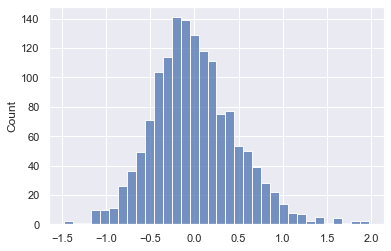

In [161]:
# reagrdons la normalité des résidus dans un histograme
sns.histplot(reg_multi.resid)
plt.show()

In [162]:
st.skew(reg_multi.resid)

0.4822524149710559

### Un skewness empirique, qui est la mesure de l'asymétrie, supérieur à 0 indique un étalement à droite comme c'est le cas ici.

In [163]:
shapiro(reg_multi.resid)[1]

8.536943374437556e-11

### Dans le cas du test de Shapiro, l'hypothèse H0 de normalité est vérifié quand la valeur est élevé, ici comme la P value est inférieure au niveau de test choisi de 0.05, l'hypothèse de normalité est rejetée.

## Colinéarité

In [164]:
var = reg_multi.model.exog
[variance_inflation_factor(var, i) for i in np.arange(1,var.shape[1])]

[1.0136128990686333,
 1.138260573608249,
 1.230114515556036,
 1.4044037781843624,
 1.576950145366581]

### VIF inférieur a 10 donc non colinéarité

## Homoscédasticité

L'homoscédasticité peut être mesurée via un test de White

In [165]:
white_test = het_white(reg_multi.resid, reg_multi.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

{'Test Statistic': 109.8601519685849, 'p-value': 2.0828244990467605e-14, 'F-Statistic': 5.853731207796846, 'F-Test p-value': 4.974865092877112e-15}


### H0 (hypothèse nulle) : homoscédasticité / H1 (hypothèse alternative) : hétéroscédasticité

### La P-value est inférieure à 5% nous pousse à rejeter l'hypothèse nulle d'homoscédasticité.

### Bien que  les hypothèses du modèle linéaire ne soient pas respectées, Un modèle linéaire est robuste sous réserve qu'il y ait une taille d'échantillon suffisante (> 1000) dans notre cas.

## Appliquons notre modèle 

In [166]:
# création d'un df avec les lignes de valeurs manquantes sans la colonne margin_low
df_manquant = df_billet.loc[df_billet['margin_low'].isnull(),['diagonal','height_left','height_right','margin_up','length']]

# on utilise les 2 variables retenu pour notre modèle
a_prevoir = df_manquant.copy()

# on prédit
prevu = reg_multi.predict(a_prevoir)
df_manquant['margin_low_pred'] = prevu

df_final = df_billet.copy()
df_final.loc[df_manquant.index, 'margin_low'] = df_manquant['margin_low_pred']
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [167]:
df_final.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [168]:
df_final.shape

(1500, 7)

                         ***************************************************

# Régression Logistique

## Analyse descriptive après régression

In [169]:
df_final.info()
df_final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


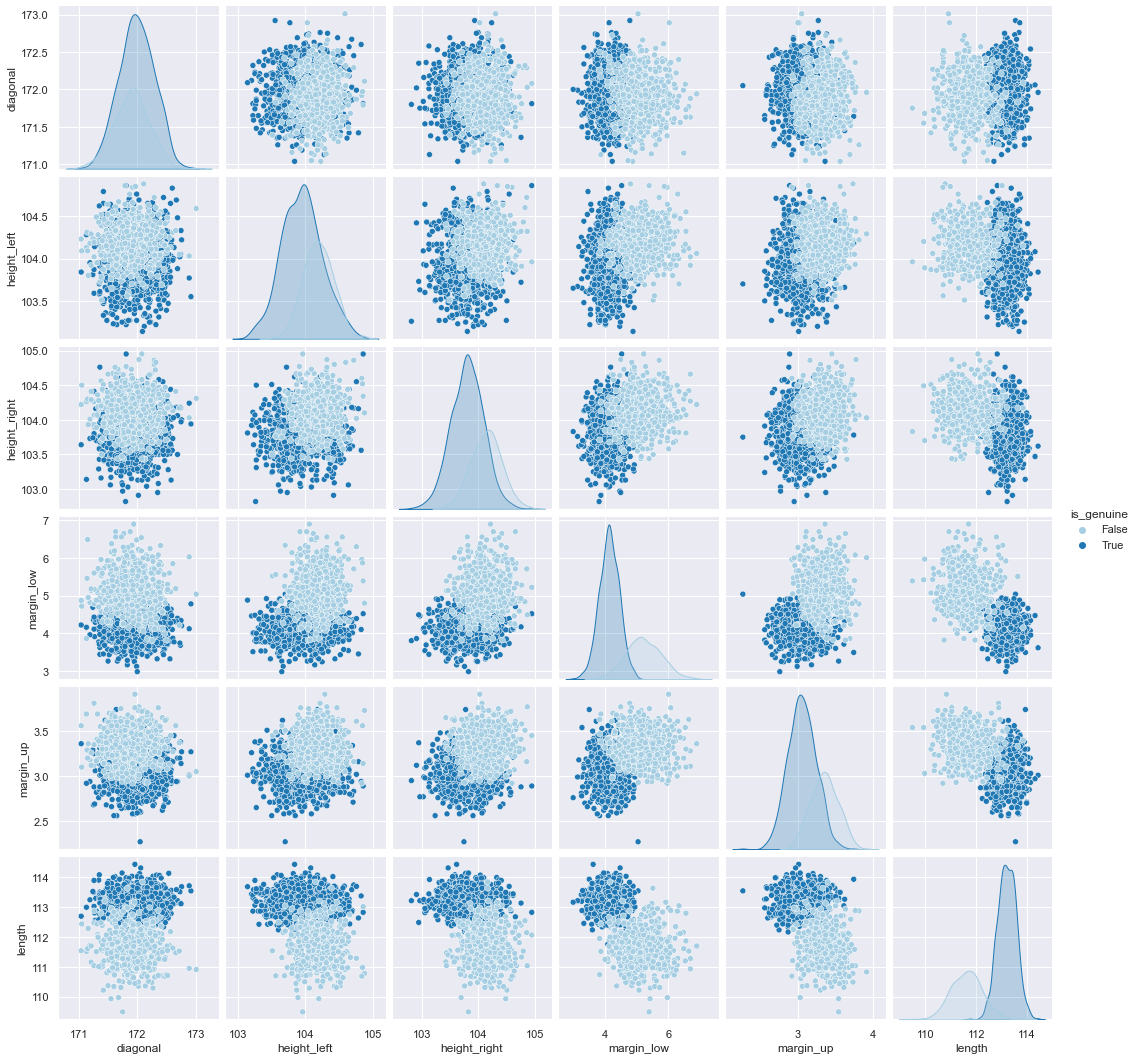

In [170]:
# regardons a quoi ressemblent nos données dans un pair plot
sns.pairplot(df_final, hue="is_genuine", palette="Paired")

### En regardant les densité et les nuages de points, on voit que les variables qui différencient le mieux les valeurs vrai ou faux sont margin_low et length

## Outliers : répartition des dimensions des billets

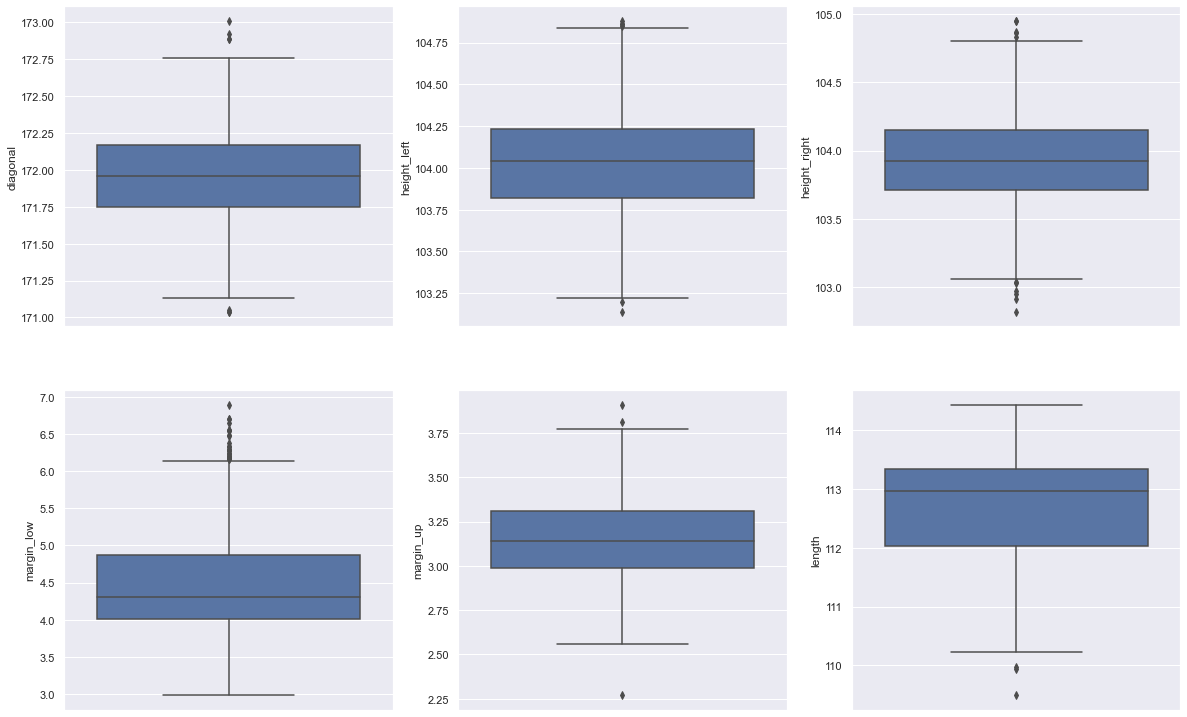

In [171]:
# affichage dans des boxplot de la répartition 
plt.figure(figsize=(20, 20))
sns.set()
plt.subplot(331)
sns.boxplot(data=df_billet,y='diagonal')
plt.subplot(332)
sns.boxplot(data=df_billet, y='height_left')
plt.subplot(333)
sns.boxplot(data=df_billet, y='height_right')
plt.subplot(334)
sns.boxplot(data=df_billet,y='margin_low')
plt.subplot(335)
sns.boxplot(data=df_billet, y='margin_up')
plt.subplot(336)
sns.boxplot(data=df_billet,y='length')
plt.show()


### Beaucoup d'outliers dans chaque variable, nous verrons comment ils se comportent pendant la régression logistique et eventuellement faire une analyse des individus atypique et influents.

                          ********************************************

## Regression logistique

In [172]:
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [173]:
#Variables explicatives
X = df_final[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

#Variable à expliquer
y = df_final.is_genuine

In [174]:
# on split en test et train le jeu de données 30/70
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [175]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)

In [176]:
#Régression logistique  
logreg = LogisticRegression()
logreg.fit(X, y)

#Stockage de prédictions
y_pred = logreg.predict(X)

In [182]:
conf_matrix = metrics.confusion_matrix(y_pred, X_train)
conf_matrix = pd.DataFrame(conf_matrix)

sns.heatmap(conf_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique\n")

ValueError: Found input variables with inconsistent numbers of samples: [1500, 1050]

In [139]:
#Composition de la matrice de confusion
vrais_pos = conf_matrix[1][1]
vrais_neg = conf_matrix[0][0]
faux_pos = conf_matrix[1][0]
faux_neg = conf_matrix[0][1]
vrais_pos, vrais_neg, faux_pos, faux_neg

(304, 139, 2, 5)

In [140]:
#Sensibilité de la régression logistique 302/(302+1)
sensi = vrais_pos / ((vrais_pos) + faux_neg)
sensi

0.9838187702265372

In [141]:
#Spécificité de la régression logistique 142/(142+5)
speci = vrais_neg / (vrais_neg + faux_pos)
speci

0.9858156028368794

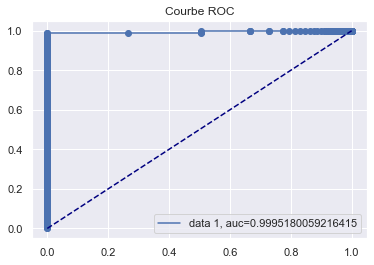

In [122]:
#Courbe Receiver Operating Characteristic (Area Under the roC) (fonction d'efficacité du recepteur)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba, sample_weight=y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, 'bo')
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Courbe ROC')
plt.legend()
plt.show()

                       ****************************************************

## Comparaison avec l'algorithme du K-means.

In [61]:
df_km = df_final.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
df_km.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [62]:
# Selectionner les valeurs 
X = df_km.values
#Centrage / réduction 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

### Regardons d'abord la methode du coude

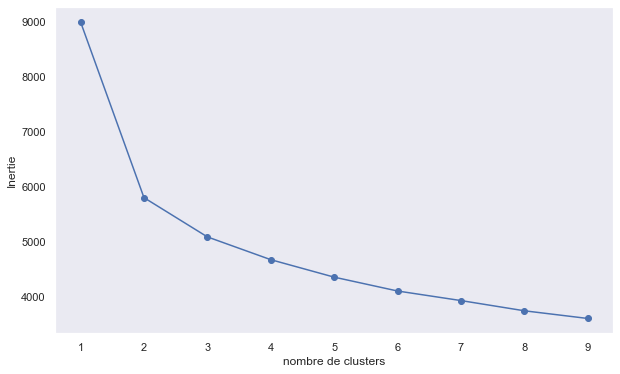

In [63]:
inertia = []
k_range=range(1,10)
for k in k_range:
    model_km = KMeans(n_clusters=k).fit(X_scaled)
    inertia.append(model_km.inertia_)
   
fig = plt.figure(figsize=(10,6))
plt.plot(k_range,inertia, marker='o' )
plt.xlabel('nombre de clusters')
plt.ylabel('Inertie')
plt.grid() 
plt.show()

### La courbe casse clairement sur 2 clusters

### Score silhouette

In [64]:
#Calcul  de la métrique "silhouette"
silhouettes = [] 


for k in range(2, 10): 
    clust = cluster.KMeans(n_clusters=k)  
    clust.fit(X)
    
    #Stockage des coefficients associés
    coef_sil = metrics.silhouette_score(X, clust.labels_)
    silhouettes.append(coef_sil)

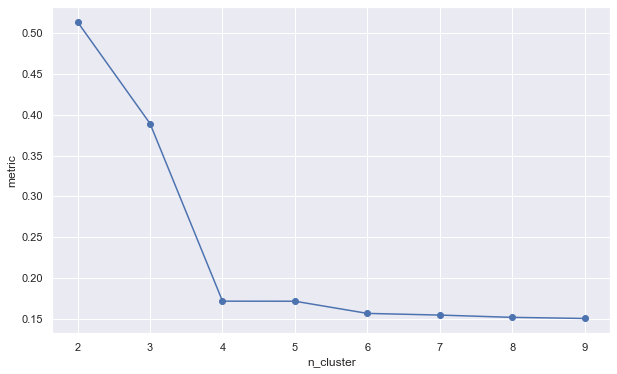

In [65]:
fig = plt.figure(figsize=(10,6))

plt.ylabel("metric")
plt.xlabel("n_cluster")

plt.plot(range(2,10), silhouettes, marker='o')
plt.show()


### Là encore le score silhouette nous indique un clustering de 2

## K-means

In [71]:
#On fit et on transforme
model_km = KMeans(n_clusters=2).fit(X_scaled)
X_test_scaled = std_scale.transform(X_test)
y_pred2 = model_km.predict(X_test_scaled)

Text(0.5, 1.0, 'Matrice de confusion du K-means\n')

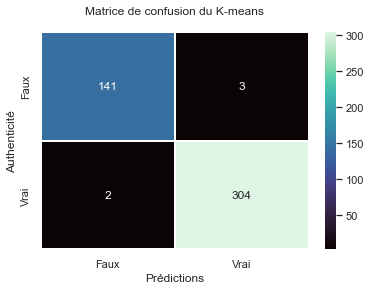

In [72]:
conf_matrix2 = metrics.confusion_matrix(y_pred2, y_test)
conf_matrix2 = pd.DataFrame(conf_matrix2)

sns.heatmap(conf_matrix2,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion du K-means\n")

In [73]:
#Composition de la matrice de confusion
vrais_posi = conf_matrix2[1][1]
vrais_nega = conf_matrix2[0][0]
faux_posi = conf_matrix2[1][0]
faux_nega = conf_matrix2[0][1]
vrais_posi, vrais_nega, faux_posi, faux_nega

(304, 141, 3, 2)

In [74]:
#Sensibilité du K_means 306/(306+1)
sensib = vrais_posi / ((vrais_posi) + faux_nega)
sensib

0.9934640522875817

In [75]:
#Spécificité du K-means 140/(140+3)
specif = vrais_nega / (vrais_nega + faux_posi)
specif

0.9791666666666666

                      ************************************************

## Conclusion

### Après avoir comparé les 2 méthodes de classification, régression logistique et K-means, les 2 sont performantes meme si la régression logistique est légèrement supérieur. Le choix de la régression logistique pour la détection de faux billet est plus efficace.

                    ***************************************************

## Test soutenance

In [4]:
# chargement du dataframe
import pandas as pd
billet = pd.read_csv("/Users/Hamza/Downloads/billets_test.csv")


In [5]:
# affichage des données

billet.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [7]:
# Import librairie et entrainement modèle
from sklearn.linear_model import LogisticRegression
X = billet.drop(['id'], axis = 1).values
y = billet['id']
logistic = LogisticRegression()
logistic.fit(X,y)

LogisticRegression()

In [8]:
# stockage
proba = logistic.predict(X)
proba

array(['B_1', 'B_2', 'B_3', 'B_4', 'B_5'], dtype=object)

In [13]:
# affichage resultat

print(pd.DataFrame({'ID' : billet['id'], 'Nature' : proba}))

    ID Nature
0  B_1    B_1
1  B_2    B_2
2  B_3    B_3
3  B_4    B_4
4  B_5    B_5
